In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
import itertools
from collections import defaultdict
from collections import Counter
import io
import gurobipy as gp
from gurobipy import GRB
from itertools import combinations
from itertools import groupby

from random import sample
import math
import json
import random
import os
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ['Computer Modern Roman'],
})
%matplotlib ipympl
from pyvis.network import Network
from bidict import bidict
# import gravis as gv
import networkx as nx
import time as t

# General functions:

In [4]:
def gen_sols_var_n(n_range,m,quer_dict,partial_dict,noise,n_sols):
    """ builds ILP to construct candidate database, based on answers to queries 
    Assumes bound on noise, n and m is known. 
    
    havent changed anything to this yet****************
    
    
    
    """
    M = gp.Model()
    M.Params.OutputFlag = 0
    
    # Initialize the decision variables
    x = np.array([[M.addVar(vtype='B', name=f"x_{i}_{j}") 
                   for j in range(m)] for i in range(n)])
    # print(x)
    
    #adding the constraints...
    quer_cons(M,x,n,quer_dict,noise)
    partial_cons(M,x,n,partial_dict)
            
    # for i in range(n-1):
    #     M.addConstr(binatodeci(x[i]) <= binatodeci(x[i+1]))
    bin_cons(M,x,n)

    # Parameters
    M.Params.PoolSearchMode = 2
    M.Params.PoolSolutions = n_sols
    # m.Params.PoolSolutions = 2
    M.Params.PoolGap = 0.0

    # Optimize
    M.optimize()
    
    # print(f"Took {M.Runtime:.2f} seconds to solve")
    
    if M.solCount == 0:
        print("infeasible")
    
    out_lst = []
    for k in range(M.SolCount):
        M.Params.SolutionNumber = k
        out_x = np.zeros_like(x)
        for i in range(len(x)):
            for j in range(len(x[0])):
                out_x[i][j] = x[i][j].Xn
        # print([var.Xn for var in m.getVars()])
        out_lst.append(out_x)
        
    return out_lst, M.Runtime

def n_sols(n,m,quer_dict,noise,n_sols,partials = dict()):
    """ builds ILP to construct candidate database, based on answers to queries 
    Assumes bound on noise, n and m is known. """
    M = gp.Model()
    M.Params.OutputFlag = 0
    
    # Initialize the decision variables
    x = np.array([[M.addVar(vtype='B', name=f"x_{i}_{j}") 
                   for j in range(m)] for i in range(n)])
    # print(x)
    # partial_dict = dict()
    #adding the constraints...
    quer_cons(M,x,n,quer_dict,noise)
    partial_cons(M,x,n,partials)
            
    # for i in range(n-1):
    #     M.addConstr(binatodeci(x[i]) <= binatodeci(x[i+1]))
    bin_cons(M,x,n)

    # Parameters
    M.Params.PoolSearchMode = 2
    M.Params.PoolSolutions = n_sols
    # m.Params.PoolSolutions = 2
    M.Params.PoolGap = 0.0

    # Optimize
    M.optimize()
    return M.SolCount



def gen_sols(n,m,quer_dict,partial_dict,noise,n_sols):
    """ builds ILP to construct candidate database, based on answers to queries 
    Assumes bound on noise, n and m is known. """
    M = gp.Model()
    M.Params.OutputFlag = 0
    
    # Initialize the decision variables
    x = np.array([[M.addVar(vtype='B', name=f"x_{i}_{j}") 
                   for j in range(m)] for i in range(n)])
    # print(x)
    
    #adding the constraints...
    quer_cons(M,x,n,quer_dict,noise)
    partial_cons(M,x,n,partial_dict)
            
    # for i in range(n-1):
    #     M.addConstr(binatodeci(x[i]) <= binatodeci(x[i+1]))
    bin_cons(M,x,n)

    # Parameters
    M.Params.PoolSearchMode = 2
    M.Params.PoolSolutions = n_sols
    # m.Params.PoolSolutions = 2
    M.Params.PoolGap = 0.0

    # Optimize
    M.optimize()
    
    # print(f"Took {M.Runtime:.2f} seconds to solve")
    
    if M.solCount == 0:
        print("infeasible")
    
    out_lst = []
    for k in range(M.SolCount):
        M.Params.SolutionNumber = k
        out_x = np.zeros_like(x)
        for i in range(len(x)):
            for j in range(len(x[0])):
                out_x[i][j] = x[i][j].Xn
        # print([var.Xn for var in m.getVars()])
        out_lst.append(out_x)
        
    return out_lst, M.Runtime

def quer_cons(M,x,n,quer_dict,noise):
    """ Adds the constraints based on the queries in quer_dict"""
    
    y_var_dict = defaultdict()
    y_p_var_dict = defaultdict()
    y_n_var_dict = defaultdict()
    
    for quer in quer_dict.keys():
        y_var_dict[quer] = []
        y_p_var_dict[quer] = []
        y_n_var_dict[quer] = []
        
        positions_0 = []
        positions_1 = []
        for i, j in zip(quer[0],quer[1]):
            if j == 0: 
                positions_0.append(i)
            elif j ==1:
                positions_1.append(i)
        for i in range(n):
            y_var_dict[quer].append(M.addVar(vtype='B', name=f"y_{quer}_{i}"))
            y_p_var_dict[quer].append(M.addVar(vtype='B', name=f"y_p_{quer}_{i}"))
            y_n_var_dict[quer].append(M.addVar(vtype='B', name=f"y_n_{quer}_{i}"))
            
            M.addConstr( len(quer[0])*y_var_dict[quer][i] + (len(quer[0])+0.5)*y_p_var_dict[quer][i] <= 
                        sum([x[i][j] for j in positions_1]) + sum([(1-x[i][j]) for j in positions_0]))
            M.addConstr( (len(quer[0])-0.5)*y_n_var_dict[quer][i] + len(quer[0])*y_var_dict[quer][i] + 
                        m*y_p_var_dict[quer][i] >= 
                        sum([x[i][j] for j in positions_1])+ sum([(1-x[i][j]) for j in positions_0]))
            M.addConstr( y_var_dict[quer][i] + y_p_var_dict[quer][i] + y_n_var_dict[quer][i] == 1)
            
        if noise == 0:
            M.addConstr(sum(y_var_dict[quer]) == quer_dict[quer])
        else:
            M.addConstr(sum(y_var_dict[quer]) <= quer_dict[quer] + noise)
            M.addConstr(sum(y_var_dict[quer]) >= quer_dict[quer] - noise)
    return None

def partial_cons(M,x,n,partial_dict):
    """ Adds the constraints based on the partial information in partial_dict"""
    
    y_var_dict_partial = defaultdict()
    y_p_var_dict_partial = defaultdict()
    y_n_var_dict_partial = defaultdict()
    
    for quer in partial_dict.keys():
        y_var_dict_partial[quer] = []
        y_p_var_dict_partial[quer] = []
        y_n_var_dict_partial[quer] = []
        
        positions_0 = []
        positions_1 = []
        for i, j in zip(quer[0],quer[1]):
            if j == 0: 
                positions_0.append(i)
            elif j ==1:
                positions_1.append(i)
        for i in range(n):
            y_var_dict_partial[quer].append(M.addVar(vtype='B', name=f"y_partial_{quer}_{i}"))
            y_p_var_dict_partial[quer].append(M.addVar(vtype='B', name=f"y_p_partial_{quer}_{i}"))
            y_n_var_dict_partial[quer].append(M.addVar(vtype='B', name=f"y_n_partial_{quer}_{i}"))
            
            M.addConstr( len(quer[0])*y_var_dict_partial[quer][i] + (len(quer[0])+0.5)*y_p_var_dict_partial[quer][i] <= 
                        sum([x[i][j] for j in positions_1]) + sum([(1-x[i][j]) for j in positions_0]))
            M.addConstr( (len(quer[0])-0.5)*y_n_var_dict_partial[quer][i] + len(quer[0])*y_var_dict_partial[quer][i] + 
                        m*y_p_var_dict_partial[quer][i] >= 
                        sum([x[i][j] for j in positions_1])+ sum([(1-x[i][j]) for j in positions_0]))
            M.addConstr( y_var_dict_partial[quer][i] + y_p_var_dict_partial[quer][i] + y_n_var_dict_partial[quer][i] == 1)
            
        # this line does the work
        M.addConstr(sum(y_var_dict_partial[quer]) >= partial_dict[quer])
        
    return None

def bin_cons(M,x,n):
    """ Adds binary symmetry breaking constraint """
    for i in range(n-1):
        M.addConstr(binatodeci(x[i]) <= binatodeci(x[i+1]))
    return None

def gen_bin_data_set(n,m):
    """n is number of people, m is number of attributes used, database is uniform random"""
    db = pd.DataFrame(np.random.randint(0,2,size=(n, m)), columns=[f'att_{x}' for x in range(m)])
    return db

def gen_powerset(k):
    """ generates a powerset of k elements """
    out = []
    for i in itertools.product([0,1],repeat=k):
        out.append(i)
    return out

def gen_queries_uniform_complete(m,n_queries):
    """Generates all possible queries of m binary attributes, 
    takes a sample of size n_queries from the set"""
        
    queries = []
    for i in range(1,m+1):
        
        combs = itertools.combinations(range(m),i)
        for comb in combs:
            for choice in gen_powerset(i):
                quer = []
                quer.append(comb)
                quer.append(choice)
                queries.append(tuple(quer))
                
    return sample(queries,min(n_queries,len(queries)))

def gen_queries_all(m):
    """Generates all possible queries of m binary attributes"""
        
    queries = []
    for i in range(1,m+1):
        
        combs = itertools.combinations(range(m),i)
        for comb in combs:
            for choice in gen_powerset(i):
                quer = []
                quer.append(comb)
                quer.append(choice)
                queries.append(tuple(quer))
                
    return queries

def gen_queries_comp(m):
    """Generates all possible queries of m binary attributes, 
    takes a sample of size n_queries from the set"""
        
    queries = []
    for i in range(1,m+1):
        
        combs = itertools.combinations(range(m),i)
        for comb in combs:
            for choice in gen_powerset(i):
                quer = []
                quer.append(comb)
                quer.append(choice)
                queries.append(tuple(quer))
                
    return queries

def gen_queries_uniform(m,n_queries):
    """Generates random queries. Chooses number of attributes uniformly over [1,m],
    Would be interested to see how this changes with a skewed distribution, also
    would be interesting how it changes if symmetry in queries is forced"""
    
    queries = []

    for i in range(n_queries):
        quer = []
        atts = np.random.randint(1,m+1)
        quer.append(tuple(sorted(sample(range(m),atts))))
        quer.append(tuple(np.random.choice([0,1], size=[atts])))
        queries.append(quer)

    queries = list(set([tuple(x) for x in queries]))

    return queries

def gen_partial_info(db,n_part,m_part):
    """ generates a partial info dict based on n_partials rows
    and m_partials attributes per individual, if no partial info, we get None type """
    
    n = db.shape[0]
    m = db.shape[1]
    
    partial_dict = defaultdict(lambda:0)
    
    if n_part == 0 or m_part == 0:
        return partial_dict
    
    row_inds = np.random.choice(n,n_part, replace = False)
    for i in row_inds:
        att_sample = np.random.choice(m,m_part, replace = False)
        lst = []
        for j in att_sample:
            lst.append(int(db[i:i+1][f"att_{j}"]))
            
        # print(att_sample,lst)
        vals = [x for _,x in sorted(zip(att_sample,lst))]
        
        partial_dict[(tuple(sorted(att_sample)),tuple(vals))] += 1
    return partial_dict
            
def quer2string(query):
    """ converts query to a string to be used by pandas 'query' function"""
    string = ""
    for pos, att in enumerate(query[0]):
        string += f'att_{att} == {query[1][pos]} & '
    return string[0:-3]

def get_counts_uniform(db,quers,noise):
    """Returns noisy count of query, noise is uniform random integer over -noise to noise (inclusive). 
    Will perturb negative counts to 0."""
    out_dict = defaultdict(int)
    for query in quers:
        out_dict[tuple(query)] = max(len(db.query(quer2string(query))) + np.random.randint(-noise,noise+1),0)
    return out_dict

def binatodeci(binary):
    return sum(val*(2**idx) for idx, val in enumerate(reversed(binary)))

def check_fixed_sols(sols):
    """Takes some candidate databases and returns which
    rows are contained in all of them, including duplicates"""
    
    if len(sols) == 1:
        return [tuple(x) for x in sols[0]]
    
    out_lst = []
    for sol in sols:
        temp = []
        for row in sol:
            temp.append(tuple(row))
        out_lst.append(temp)
    # print(out_lst)

    fixed_sols = []
    for row in out_lst[0]:
        count = 0
        for sol in out_lst[1:]:
            if row in sol:
                sol.remove(row)
                count += 1
            # else:
            #     break
        if count == len(sols) - 1:
            fixed_sols.append(row)
    return fixed_sols

def total_sim(sol,db):
    count = 0
    for i, val_i in enumerate(db):
        for j, val_j in enumerate(val_i):
            # print(val_j, sol[i][j])
            if val_j != sol[i][j]:
                count += 1
            
    return  1 - count/(len(db[0])*len(db))

def gen_cij(db,sol,i,j):
    """ computes cost of assigning row i of solution 
    to row j of database in terms of L1 norm"""
    
    cost = sum([abs(db[j][k]-sol[i][k]) for k in range(len(sol[0]))])
    return cost

def ass_ILP(db,sol):
    """ Creates an optimal assignment of rows in the solution 
    to the rows in the true database, the objective function value
    is returned and is the smallest number of differences between
    solution and true database, based on row swapping"""
    
    n = len(sol)
    M = gp.Model()
    M.Params.OutputFlag = 0
    
    x = np.array([[M.addVar(vtype='B', name=f"x_{i}_{j}") 
               for j in range(n)] for i in range(n)])
    
    for i in range(n):
        M.addConstr(sum(x[i,:]) == 1)
        M.addConstr(sum(x[:,i]) == 1)
        
    M.setObjective(sum([sum([x[i][j]*gen_cij(db,sol,i,j) for j in range(n)]) for i in range(n)]), GRB.MINIMIZE)
    
    M.optimize()
    
    out_x = np.zeros_like(x)
    for i in range(len(x)):
        for j in range(len(x[0])):
            out_x[i][j] = x[i][j].Xn
    # print(out_x)
    
    return 1 - M.ObjVal/(len(db)*len(db[0]))

def get_counts_uniform_seed(db,quers,noise,quer_seed_dict):
    """Returns noisy count of query, noise is uniform random integer over -noise to noise (inclusive). 
    Will perturb negative counts to 0."""
    out_dict = defaultdict(int)
    for query in quers:
        out_dict[tuple(query)] = max(len(db.query(quer2string(query))) + quer2noise_uniform(query,quer_seed_dict,noise),0)
        # print(np.random.randint(-noise,noise+1))
    return out_dict

def get_counts_triangle_seed(db,quers,noise,quer_seed_dict):
    """Returns noisy count of query, noise is symmetric rounded triangle [-noise, +noise]
    Will perturb negative counts to 0."""
    out_dict = defaultdict(int)
    for query in quers:
        out_dict[tuple(query)] = max(len(db.query(quer2string(query))) + quer2noise_triangle(query,quer_seed_dict,noise),0)
        # print(np.random.randint(-noise,noise+1))
    return out_dict

def get_counts_triangle(db,quers,noise):
    """Returns noisy count of query, noise is uniform random integer over -noise to noise (inclusive). 
    Will perturb negative counts to 0."""
    out_dict = defaultdict(int)
    for query in quers:
        if noise == 0:
            actual_noise = 0
        else:
            actual_noise = round(np.random.triangular(-noise, 0, noise))
        out_dict[tuple(query)] = max(len(db.query(quer2string(query))) + actual_noise,0)
    return out_dict

def quer2noise_uniform(query,quer_seed_dict,noise):
    """ generates noise from discrete-RV: U({-noise,noise})
    using the seed in the query dict"""
    # print(query)
    if quer_seed_dict != None:
        np.random.seed(quer_seed_dict[query])
    return np.random.randint(-noise,noise+1)

def quer2noise_triangle(query,quer_seed_dict,noise):
    """ generates noise from rounded triangle distribution over -noise to +noise, median at 0,
    using the seed in the query dict"""
    # print(query)
    if quer_seed_dict != None:
        np.random.seed(quer_seed_dict[query])
    return round(np.random.triangular(-noise, 0, noise))

def gen_powerset_test(k):
    """ generates a powerset of k elements """
    out = []
    for i in itertools.product([0,1],repeat=k):
        out.append(i)
    return out

def flipped_choice(choice):
    """ returns the compliment of a query"""
    return tuple([abs(1-x) for x in choice])

def gen_queries_compliment(m,n_queries):
    """Generates all possible queries of m binary attributes, 
    takes a sample of size n_queries from the set"""
        
    queries = []
    for i in range(1,m+1):
        
        combs = itertools.combinations(range(m),i)
        for comb in combs:
            used = []
            for choice in gen_powerset(i):
                if choice not in used:
                    quer = []
                    used.append(flipped_choice(choice))
                    quer.append(comb)
                    quer.append(choice)
                    queries.append(tuple(quer))
            
            
    sampled = sample(queries,min(int(n_queries/2),len(queries)))
    sample_with_compliment = list(sampled)
    for quer in sampled:
        sample_with_compliment.append((quer[0],flipped_choice(quer[1])))  
    
    return sample_with_compliment

def query_seed_dict(m):
    """ assigns a seed to every possible query based on the m attributes"""
    quer_dict = defaultdict()
    queries = gen_queries_uniform_complete(m,max_quers(m))
    for query in queries:
        quer_dict[query] = int(np.random.uniform()*100000)
    # print(quer_dict)
    return quer_dict

def max_quers(m):
    """returns the maximum number of queries possible from m binary attributes"""
    tot = 0
    for i in range(1,m+1):
        tot += (math.factorial(m)/(math.factorial(i)*math.factorial(m-i)))*(2**i)
    return int(tot)

def gen_query_row_pair(N_q_start,n,m,c,N_sols):
    """ creates a database, and returns pairs of backbone solutions and the additional queries 
    (and their values) it took to find that backbone solution. Starts with N_q_start queries
    and considers N_sols to create the backbone solutions"""
    
    max_quer = max_quers(m)
    print(max_quer)
    noise = c
    db = gen_bin_data_set(n,m)
    display(db)
    
    # might not need to be shuffled, just making sure
    quers = gen_queries_comp(m)
    np.random.shuffle(quers)
    quer_seed_dict = query_seed_dict(m)
    quer_dict_all = get_counts_uniform_seed(db,quers,noise,quer_seed_dict)

    db_tup = sorted([tuple(x) for x in list(db.to_numpy())],key=binatodeci)
    return_lst = []
    backbones = []
    fixed_sols =[]
    quer_set = set()

    N_q = min(int(N_q_start),max_quer)
    dictfilt = lambda x, y: dict([ (i,x[i]) for i in x if i in set(y) ])
    
    while (len(backbones) != n) and (N_q != max_quer+1):
        
        queries = quers[0:N_q]
        quer_dict = dict((k, quer_dict_all[k]) for k in queries)
        sols_all = gen_sols(n,m,quer_dict,noise,N_sols)
        sols = np.array(sols_all[0], dtype=int) 
        
        if len(sols) < N_sols:
            fixed_sols = check_fixed_sols(sols)
            
        if len(fixed_sols) > len(backbones):

            fs_c = Counter(fixed_sols)
            b_c = Counter(backbones)
            if sum(fs_c.values()) > sum(b_c.values()):
                new_bones = [x for x in fs_c-b_c]
            crit_query = {queries[N_q-1]: quer_dict[queries[N_q-1]]}
            return_lst.append((new_bones,crit_query,dictfilt(quer_dict,set(queries).difference(quer_set))))
            backbones += new_bones
            quer_set.update(set(queries))
        N_q += 1
        
    if N_q == max_quer -1:
        print("Used all queries")
    return return_lst
        
def get_results_old(c,n,m,N_q,N_sols,dist,n_part,m_part):
    """ Returns some performance metrics for a randomly generated database, with random noise"""   
    noise = c
    db = gen_bin_data_set(n,m)
    # print(db)
    quers = gen_queries_uniform_complete(m,N_q)
    
    if n_part == 0 or m_part == 0:
        partial_dict = None
    else:
        partial_dict = gen_partial_info(db,n_part,m_part)
    
    if dist == 'uniform':
        quer_dict = get_counts_uniform(db,quers,noise)
    elif dist == 'triangle':
        quer_dict = get_counts_triangle(db,quers,noise)
    else:
        return "unrecognised distribution"
    
    
    db_tup = sorted([tuple(x) for x in list(db.to_numpy())],key=binatodeci)
    # print(db_tup)

    #solving:
    new_n = n 
    
    sols_all = gen_sols(new_n,m,quer_dict,partial_dict,noise,N_sols)
    sols = np.array(sols_all[0], dtype=int) 
    time = sols_all[1] 
    
    backbone_size = 0
    if len(sols) < N_sols:
        fixed_sols = check_fixed_sols(sols)
        backbone_size = len(fixed_sols)/n
    
    row_sims = []
    tot_sims = []
    counter_sols = []
    
    for sol in sols:
        sol_tup = [tuple(x) for x in sol]
        # print(sol_tup)
        counter_sols.append(Counter(list(sol_tup)))
        sol_tup, common = sol_tup[:], [ e for e in db_tup if e in sol_tup and (sol_tup.pop(sol_tup.index(e)) or True)]
        # tot_sims.append(ass_ILP(db_tup,sol_tup))
        row_sims.append(len(common)/n)
        
    crit_query_count = 0
    query_items = quer_dict.items()
    for query in gen_crit_queries(db_tup,m,c):
        if query in query_items:
            crit_query_count += 1
    
    returns = {
        'maximum queries': max_quers(m),
        'backbone_size': backbone_size, 
        # 'tot_avg': np.mean(tot_sims), 
        # 'tot_min': np.min(tot_sims),
        'row_avg': np.mean(row_sims), 
        # 'row_min': np.min(row_sims), 
        'solve_time': time, 
        'N_sols_actual': len(sols),
        "Contained": Counter(db_tup) in counter_sols,
        "crit_queries": crit_query_count
    }
    # print(counter_sols)
    return returns

def get_results(db,quer_seed_dict,quers,c,n,m,N_sols,dist,partial_dict):
    """ Returns some performance metrics for a randomly generated database, with random noise....
    
    db: is database as a pandas array
    seed_dict: a dictionary assigning a seed to every possible query
    quers: a bunch of queries in a two-tuple form, will get turned into a noisy count based on 'db', 'dist' and 'seed_dict'
    c: bound on noise, integer
    n: size of database (eventually want this to get rid of this...)
    m: number of attributes
    N_sols: number of solutions to enumerate when solving
    dist: rn either 'uniform' or 'triangle', the distribution of the noise
    partial_dict: dictionary containing partial information.
    
    """   
    
    
    noise = c
#     # print(db)
#     quers = gen_queries_uniform_complete(m,N_q)
    
#     if n_part == 0 or m_part == 0:
#         partial_dict = None
#     else:
#         partial_dict = gen_partial_info(db,n_part,m_part)


    if dist == 'uniform':
        quer_dict = get_counts_uniform_seed(db,quers,noise,quer_seed_dict)
    elif dist == 'triangle':
        quer_dict = get_counts_triangle_seed(db,quers,noise,quer_seed_dict)
    else:
        return "unrecognised distribution"

    
    
    db_tup = sorted([tuple(x) for x in list(db.to_numpy())],key=binatodeci)
    # print(db_tup)

    #solving:
    new_n = n 
    
    sols_all = gen_sols(new_n,m,quer_dict,partial_dict,noise,N_sols)
    sols = np.array(sols_all[0], dtype=int) 
    time = sols_all[1] 
    
    backbone_size = 0
    if len(sols) < N_sols:
        fixed_sols = check_fixed_sols(sols)
        backbone_size = len(fixed_sols)/n
    
    row_sims = []
    tot_sims = []
    counter_sols = []
    
    
    sol_set = set()
    for sol in sols:
        sol_tup = [tuple(x) for x in sol]
        sol_set.add(tuple(sol_tup))
        # print(sol_tup)
        counter_sols.append(Counter(list(sol_tup)))
        sol_tup, common = sol_tup[:], [ e for e in db_tup if e in sol_tup and (sol_tup.pop(sol_tup.index(e)) or True)]
        # tot_sims.append(ass_ILP(db_tup,sol_tup))
        row_sims.append(len(common)/n)
        
    crit_query_count = 0
    query_items = quer_dict.items()
    for query in gen_crit_queries(db_tup,m,c):
        if query in query_items:
            crit_query_count += 1
            
    
    # print(len(sol_set))
    # print(sols)
    returns = {
        'maximum queries': max_quers(m),
        'backbone_size': backbone_size, 
        # 'tot_avg': np.mean(tot_sims), 
        # 'tot_min': np.min(tot_sims),
        'row_avg': np.mean(row_sims), 
        # 'row_min': np.min(row_sims), 
        'solve_time': time, 
        'N_sols_actual': len(sols),
        "Contained": Counter(db_tup) in counter_sols,
        "crit_queries": crit_query_count
    }
    # print(counter_sols)
    return returns


def gen_crit_queries(db,m,c):
    outputs = []
    A = tuple(range(m))
    for row in db:
        V = tuple(row)
        for i in range(3):
            outputs.append(((A,V),c+i))
    return outputs

def compare_noise_types(n,m,c,N_q,N_sols,N_trials,n_part,m_part):
    # results = defaultdict(lambda: defaultdict())
    results = defaultdict(list)
    tri_list = []
    uni_list = []
    unique_counts = defaultdict(lambda:0)
    quer_seed_dict = None
    
    for i in range(N_trials):
        for dist in ['triangle','uniform']:
            quers = gen_queries_uniform_complete(m,N_q)
            db = gen_bin_data_set(n,m)
            partial_dict = gen_partial_info(db,n_part,m_part)
            
            temp_res = get_results(db,quer_seed_dict,quers,c,n,m,N_sols,dist,partial_dict)
            # temp_res = get_results(c,n,m,N_q,N_sols,dist)
            results[dist].append(temp_res)
            if temp_res['N_sols_actual'] == 1:
                unique_counts[dist] += 1
    
    out_results = defaultdict(lambda: defaultdict())
    for dist in ['triangle','uniform']:
        df = pd.DataFrame(results[dist])
        out_results[dist] = dict(df.mean()) 
        out_results[dist]['frac_solved_uniqely'] = unique_counts[dist]/N_trials
        out_results[dist]['params'] = {'n': n, 'm': m, 'c': c, 'N_q': N_q, 'N_sols': N_sols, 'N_trials': N_trials}
    return out_results

def gen_queries_count_size(db,c,dist,quer_seed_dict,N_q,first):
    quers_all = gen_queries_uniform_complete(m,max_quers(m))
    if dist == 'uniform': quer_counts = get_counts_uniform_seed(db,quers_all,c,quer_seed_dict)
    if dist == 'triangle': quer_counts = get_counts_triangle_seed(db,quers_all,c,quer_seed_dict)
    
    if first == 'large':
        sorted_quers = {k: v for k, v in sorted(quer_counts.items(), key=lambda item: item[1], reverse = True)}
    elif first == 'small':
        sorted_quers = {k: v for k, v in sorted(quer_counts.items(), key=lambda item: item[1])}
        
    first_Nq_quers = {k: sorted_quers[k] for k in list(sorted_quers.keys())[0:N_q]}
    # print(first_Nq_quers)
    return list(first_Nq_quers.keys())

def gen_queries(m,n,db,c,quer_seed_dict,N_q,quer_type,dist):
    
    N_q = min(N_q,max_quers(m))
    all_quers = gen_queries_all(m)
    
    if quer_type == 'uniform_random':
        quers = gen_queries_uniform_complete(m,N_q)
    
    elif quer_type == 'large_counts_first':
        quers = gen_queries_count_size(db,c,dist,quer_seed_dict,N_q,'large')
        
    elif quer_type == 'small_counts_first':
        quers = gen_queries_count_size(db,c,dist,quer_seed_dict,N_q,'small')
        
    elif quer_type == 'many_atts_first':
        quers = sorted(all_quers,key =lambda item: len(item[0]), reverse = True)[0:N_q]
    
    elif quer_type == 'few_atts_first':
        quers = sorted(all_quers,key =lambda item: len(item[0]))[0:N_q]
        
    return quers
        
    

def compare_query_types(n,m,c,N_q,N_sols,N_trials,dist,quer_types):
    
    # results = defaultdict(lambda: defaultdict())
    results = defaultdict(list)
    normal_list = []
    partial_list = []
    unique_counts = defaultdict(lambda:0)
    for i in range(N_trials):
        quer_seed_dict = query_seed_dict(m)
        # quers = gen_queries_uniform_complete(m,N_q)
        db = gen_bin_data_set(n,m)
        for quer_type in quer_types:
            # partial_dict = gen_partial_info(db,partial[0],partial[1])
            # print(partial_dict)
            
            partial_dict = dict()
            quers = gen_queries(m,n,db,c,quer_seed_dict,N_q,quer_type,dist)
            temp_res = get_results(db,quer_seed_dict,quers,c,n,m,N_sols,dist,partial_dict)
            # temp_res = get_results(c,n,m,N_q,N_sols,dist,partial[0],partial[1])
            results[quer_type].append(temp_res)
            if temp_res['N_sols_actual'] == 1:
                unique_counts[quer_type] += 1
    
    out_results = defaultdict(lambda: defaultdict())
    for quer_type in quer_types:
        df = pd.DataFrame(results[quer_type])
        out_results[quer_type] = dict(df.mean()) 
        out_results[quer_type]['frac_solved_uniqely'] = unique_counts[quer_type]/N_trials
        out_results[quer_type]['params'] = {'n': int(n), 'm': int(m), 'c': int(c), 'N_q': int(N_q), 
                                               'N_sols': int(N_sols), 'N_trials': int(N_trials)}
        # out_results[]
        
    return out_results

def compare_partial_info(n,m,c,N_q,N_sols,N_trials,dist,partials):
    """partials is a list of 2-element lists, where the first position is n_part,
    the number of people to generate partial info from, and second is m_part, 
    the number of attributes for each person to 'know'. Comapres each 2-element list, 
    asking N_q queries on each, averaging N_trials times
    
    should this all be done with additive query style? 
    
    """
    
    # results = defaultdict(lambda: defaultdict())
    results = defaultdict(list)
    normal_list = []
    partial_list = []
    unique_counts = defaultdict(lambda:0)
    for i in range(N_trials):
        quer_seed_dict = query_seed_dict(m)
        quers = gen_queries_uniform_complete(m,N_q)
        db = gen_bin_data_set(n,m)
        for partial in partials:
            partial_dict = gen_partial_info(db,partial[0],partial[1])
            # print(partial_dict)
            temp_res = get_results(db,quer_seed_dict,quers,c,n,m,N_sols,dist,partial_dict)
            # temp_res = get_results(c,n,m,N_q,N_sols,dist,partial[0],partial[1])
            results[str(partial)].append(temp_res)
            if temp_res['N_sols_actual'] == 1:
                unique_counts[str(partial)] += 1
    
    out_results = defaultdict(lambda: defaultdict())
    for partial in partials:
        df = pd.DataFrame(results[str(partial)])
        out_results[str(partial)] = dict(df.mean()) 
        out_results[str(partial)]['frac_solved_uniqely'] = unique_counts[tuple(partial)]/N_trials
        out_results[str(partial)]['params'] = {'n': int(n), 'm': int(m), 'c': int(c), 'N_q': int(N_q), 
                                               'N_sols': int(N_sols), 'N_trials': int(N_trials)}
        # out_results[]
    return out_results

def single_basic_run(n,m,c,N_q,N_sols,N_trials,dist,n_part,m_part):
    """ Generates a dataset and solves, averaging over N_trials times.
    returns a dictionary with all the performance 'metrics'"""
    
    out_lst = []
    unique_counts = 0
    for i in range(N_trials):
        quer_seed_dict = query_seed_dict(m)
        quers = gen_queries_uniform_complete(m,N_q)
        db = gen_bin_data_set(n,m)
        # print(db)
        partial_dict = gen_partial_info(db,n_part,m_part)
        # print(partial_dict)
        temp_res = get_results(db,quer_seed_dict,quers,c,n,m,N_sols,dist,partial_dict)
        out_lst.append(temp_res)
        if temp_res['N_sols_actual'] == 1:
            unique_counts += 1
            
    df = pd.DataFrame(out_lst)
    out_dict = dict(df.mean()) 
    out_dict['frac_solved_uniqely'] = unique_counts/N_trials

    return out_dict
    
def compare_query_types_additive(n,m,c,N_q_range,N_sols,N_trials,dist,quer_types):
    
    # results = defaultdict(lambda: defaultdict())
    results = defaultdict()
    out_lst = []
    for i in range(N_trials):
        quer_seed_dict = query_seed_dict(m)
        db = gen_bin_data_set(n,m)
        quers_all = defaultdict()
        for quer_type in quer_types:
            quers_all[quer_type] = gen_queries(m,n,db,c,quer_seed_dict,max_quers(m),quer_type,dist)
            
        partial_dict = dict()
        for N_q_try in N_q_range:
            N_q = int(min(N_q_try,max_quers(m)))

            temp_dict = defaultdict()
            
            for quer_type in quer_types:
                
                quers = quers_all[quer_type][0:N_q]
                temp_res = get_results(db,quer_seed_dict,quers,c,n,m,N_sols,dist,partial_dict)
                temp_dict[quer_type] = temp_res
                
            results[N_q] = temp_dict
            
        out_lst.append(results)
    return ave(out_lst)

def ave(d):
    """given a list of nested dictionaries, it will return a dictionary of averages 
    in the same format as the individual dicts"""
    _data = sorted([i for b in d for i in b.items()], key=lambda x:x[0])
    _d = [(a, [j for _, j in b]) for a, b in groupby(_data, key=lambda x:x[0])]
    return {a:ave(b) if isinstance(b[0], dict) else sum(b)/float(len(b)) for a, b in _d}

def get_quer_counts(db,m,c,quer_seed_dict,dist):
    quers = quer_seed_dict.keys()
    if dist == 'uniform':
        quer_dict = get_counts_uniform_seed(db,quers,c,quer_seed_dict)
    elif dist == 'triangle':
        quer_dict = get_counts_triangle_seed(db,quers,c,quer_seed_dict)
    else:
        return "unrecognised distribution"
    return quer_dict

def path2filename(path):
    return path.lstrip(os.getcwd())

def my_add_nodes(paths_used,network,res_dict,numbering,node_scaling):
    # net.add_node('a', hidden = True, value = 0)
    path_nodes = Counter()
    # for i in range(min(len(res_dict.values()),paths_used)):
    for i in res_dict.keys():
        path_nodes.update(res_dict[str(i)][0])
        # path_nodes.update([1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1])
    # print(path_nodes)
    not_visited = list(set(numbering.values()) - set(path_nodes.keys()))
    for query in path_nodes.keys():
        net.add_node(query, str(query),
                     size=node_scaling*path_nodes[query], 
                     # value=50, 
                     color = 'blue', 
                     title= str(numbering.inverse[query])+ "\n"+ "visits: " + str(path_nodes[query])
                 # level = len(query[0])
                )
    for query in not_visited:
        net.add_node(query, size=10, color = 'green', title = str(numbering.inverse[query])
                 # level = len(query[0])
                )
    return None

def my_add_edges(paths_used,res_dict,colour,network):
    # network.add_edge(1,1,value = 0, hidden = True)
    # for j in range(min(len(res_dict.values()),paths_used)):
    for j in res_dict.keys():
        path = res_dict[str(j)][0]
        temp_col = "#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
        # print(temp_col)
        for i in range(len(path) - 1):
            # np.random.seed(np.random.choice(range(100000)))
            network.add_edge(int(path[i]),int(path[i+1]), color = temp_col, size =0.1)
    return None

def gen_paths_SA(numbering,N_trials,dist,n_iters_SA,repeats,alpha,t_0,quer_counts,n,m,c,N_sols,k):
    
    results = defaultdict()
    db = gen_bin_data_set(n,m)
    for i in range(N_trials):
        if i%10 ==1:
            print(i)
        quer_seed_dict = query_seed_dict(m)
        quer_counts = get_quer_counts(db,m,c,quer_seed_dict,dist)
        results[i] = simu_annealing(n_iters_SA,repeats,alpha,t_0,quer_counts,n,m,c,N_sols,k,numbering)
        
    return results

def gen_paths_SA_additive_k(numbering,dist,n_iters_SA,repeats,alpha,t_0,quer_counts,n,m,c,N_sols,k_low,k_high):
    
    results = defaultdict()
    db = gen_bin_data_set(n,m)
    quer_seed_dict = query_seed_dict(m)
    quer_counts = get_quer_counts(db,m,c,quer_seed_dict,dist)
    for k in range(k_low,k_high+1):
        if k%5 ==1:
            print(k)
        results[k] = simu_annealing(n_iters_SA,repeats,alpha,t_0,quer_counts,n,m,c,N_sols,k,numbering)
        
    return results

def genetic_algo(n_iters, pop_size,n_parents, n_crossovers, n_mutants, quer_counts,n,m,c,N_sols,k,numbering):
    largest_number = max_quers(m)
    initial_pop = [np.random.choice(list(range(largest_number)), k, replace = False) for x in range(pop_size)]
    fit_dict = defaultdict()
    for i in initial_pop:
        fit_dict[tuple(i)] = get_fitness(i,n,m,c,quer_counts,N_sols,numbering)
    
    for i in range(n_iters):
        if len(set(fit_dict.keys())) <= 3:
            return list(set(fit_dict.keys()))[0], fit_dict[list(set(fit_dict.keys()))[0]]
        parents = choose_parents(fit_dict,n_parents)
        children = breed(parents,n_crossovers,largest_number)
        pop = parents+children
        pop += mutate(pop,n_mutants,largest_number)
        new_fit_dict = cull(pop,fit_dict,pop_size,n,m,c,quer_counts,N_sols,numbering)
        fit_dict = dict(new_fit_dict)
        
        ####this is a shitty fix - change this
        if len(set(fit_dict.values())) == 1:
            break
    
    min_fit = min(fit_dict.values())
    for i in fit_dict.keys():
        if fit_dict[i] == min_fit:
            return sorted(i), fit_dict[i]
    
def get_fitness(sol,n,m,c,quer_counts,N_sols,numbering):
    quers = []
    for num in sol:
        quers.append(numbering.inverse[num])
    return get_n_sols(n,m,c,quers,quer_counts,N_sols)

def choose_parents(fit_dict,n_parents):
    choices = tuple(fit_dict.keys())
    n_sol_lst = []
    tot = sum(fit_dict.values())
    for choice in choices:
        n_sol_lst.append((fit_dict[choice]))
    if len(set(n_sol_lst)) == 1:
        probs = np.array([1/len(n_sol_lst)]*len(n_sol_lst))
    else:
        probs = []
        max_lst = max(n_sol_lst)
        for i in n_sol_lst:
            prob = (max_lst - i)/sum([max_lst - x for x in n_sol_lst])
            if prob == 0:
                prob += 0.001
            probs.append(prob)
        probs = np.array(probs)
    probs /= probs.sum()
    # print(probs)
    choices_index = np.random.choice(range(len(choices)), n_parents, replace=False, p=probs)
    return [choices[i] for i in choices_index]

def breed(parents,n_crossovers,largest_number):
    children = []
    for i in range(n_crossovers):
        choice_index = np.random.choice(range(len(parents)), 2, replace= False)
        couple = [parents[i] for i in choice_index]
        children += crossover(couple,largest_number)
    return children 

def crossover(couple,largest_number):
    parent1 = couple[0]
    parent2 = couple[1]
    point = np.random.randint(0,len(couple[0])+1)
    child1 = parent1[0:point] + parent2[point:]
    child2 = parent2[0:point] + parent1[point:]
    return [fix_child(child1,largest_number), fix_child(child2,largest_number)]
    
def fix_child(child,largest_number):
    child_set = set(child)
    new_choices = np.random.choice(list(set(range(largest_number))-child_set),len(child) - len(child_set), replace= False )
    return list(child_set.union(new_choices))

def cull(pop,fit_dict,pop_size,n,m,c,quer_counts,N_sols,numbering):
    for i_ in pop:
        i = tuple(i_)
        if i not in fit_dict.keys():
            fit_dict[i] = get_fitness(i,n,m,c,quer_counts,N_sols,numbering)
    sorted_pop = list(sorted(fit_dict.items(), key=lambda x:x[1]))
    culled_pop = [sorted_pop[x][0] for x in range(pop_size)]
    new_fit_dict = defaultdict()
    for i in culled_pop:
        new_fit_dict[i] = fit_dict[i]
    return new_fit_dict

def mutate(pop,n_mutants,largest_number):
    mutant_choice = np.random.choice(range(len(pop)), n_mutants)
    mutated = []
    for choice in mutant_choice:
        ind = pop[choice]
        bit_choice = np.random.choice(range(len(ind)))
        new_ind = list(ind)
        new_quer = int(np.random.choice(list(set(range(largest_number))-set(ind))))
        new_ind[bit_choice] = new_quer
        mutated.append(new_ind)
    return mutated

def simu_annealing(n_iters,repeats,alpha,t_0,quer_counts,n,m,c,N_sols,k,numbering):
    
    largest_number = max_quers(m)
    fit_dict = defaultdict()
    current_sol = tuple(np.random.choice(list(range(largest_number)), k, replace = False))
    fit_dict['current_sol'] = get_fitness(current_sol,n,m,c,quer_counts,N_sols,numbering)
    temp = t_0
    last_ = [i for i in range(repeats)]
    
    for i in range(n_iters):
        if i >= n_iters*0.5:
            last_[i%repeats] = int(fit_dict['current_sol'])
            if len(set(last_)) == 1:
                # print(i)
                break
        new_sol = find_neighbour(current_sol,largest_number)
        fit_dict['new_sol'] = get_fitness(new_sol,n,m,c,quer_counts,N_sols,numbering)
        # print(fit_dict)
        change = fit_dict['new_sol'] - fit_dict['current_sol']
        # print(change)
        p = get_prob(temp,change)
        # print(p)
        if np.random.uniform() < p:
            current_sol = tuple(new_sol)
            fit_dict['current_sol'] = int(fit_dict['new_sol'])
        temp = temp*alpha
    # print(i)
    return (tuple(sorted([int(x) for x in current_sol])), get_fitness(current_sol,n,m,c,quer_counts,N_sols,numbering))
        
def get_prob(temp,change):
    if change <= 0:
        p = 1
    else:
        p = (math.e)**(-change/temp)
    return p
            
def find_neighbour(sol,largest_number):
    bit_choice = np.random.choice(range(len(sol)))
    new_ind = list(sol)
    new_quer = int(np.random.choice(list(set(range(largest_number))-set(sol))))
    new_ind[bit_choice] = new_quer
    return tuple(new_ind)

def produce_paths(db,quer_seed_dict,n,m,c,dist,N_sols,k,N_paths,numbering):
    """k is path length"""
    
    partial_dict = dict()
    all_quers = list(quer_seed_dict.keys()) 

    paths = []
    sols_path_dict = defaultdict()
    backbone_path_dict = defaultdict()
    for i in range(N_paths):
        path = tuple(np.random.choice(list(numbering.inverse.keys()),min(k,max_quers(m)), replace = False))
        paths.append(path)
    for path in paths:
        quers = [numbering.inverse[x] for x in path]
        res = get_results(db,quer_seed_dict,quers,c,n,m,N_sols,dist,partial_dict)
        sols_path_dict[path] = res['N_sols_actual']
        backbone_path_dict[path] = res['backbone_size']
        
    return sols_path_dict, backbone_path_dict
    
def good_paths(path_dicts, numbering, sol_thresh, bb_thresh):
    """a path is a good path if it has leq sol_thresh number of feasible solutions, 
    or if it has geq bb_thresh backbone fraction."""
    
    good_paths = []
    good_quer_count = Counter()
    quer_count = Counter()

    for path in path_dicts[0].keys():
        quer_count.update(path)
        if path_dicts[0][path] <= sol_thresh or path_dicts[1][path] >= bb_thresh:
            good_paths.append(path)
            good_quer_count.update(path)
    return good_paths, good_quer_count

def quer_perf_avg(path_dicts,numbering):

    quer_score_dict = defaultdict(lambda: 0)
    quer_count = Counter()
    # print(path_dicts)
    
    for path in path_dicts[0].keys():
        quer_count.update(path)
        for quer in path:
            # print(quer)
            quer_score_dict[quer] += path_dicts[0][path]
    for quer in quer_score_dict.keys():
        quer_score_dict[quer] /= quer_count[quer]
    return quer_score_dict

def get_n_sols(n,m,c,quers,quer_counts,N_sols):
    """returns number of feasible there are for choice of queries, where
    info about database + noisy counts is given in quer_counts"""
    quer_dict = defaultdict()
    for quer in quers:
        quer_dict[quer] = quer_counts[quer]
    return n_sols(n,m,quer_dict,c,N_sols)

def produce_count(dist,quer_seed_dict,db,quer,c):
    quers = [quer]
    if dist == 'uniform':
            quer_dict = get_counts_uniform_seed(db,quers,c,quer_seed_dict)
    elif dist == 'triangle':
        quer_dict = get_counts_triangle_seed(db,quers,c,quer_seed_dict)
    return list(quer_dict.values())[0]

def sort_quer(quer):
    vals = [x for _,x in sorted(zip(quer[0],quer[1]))]
    return (tuple(sorted(quer[0])),tuple(vals))

def gen_queries_algo(db,m,quer_seed_dict,dist,c,N_q):
    
    quers = defaultdict()
    seeds = np.random.randint(0,100000,1000)
    i=0
    
    while len(quers.keys()) < min(max_quers(m),N_q):
        
        np.random.seed(seeds[i])
        order = list(np.random.choice(list(range(m)),m, replace = False))
        # print(order)
        A = []
        V = []
        for i in order:
            A.append(i)
            quer0 = sort_quer([A,V+[0]])
            quer1 = sort_quer([A,V+[1]])
            
            val0 = produce_count(dist,quer_seed_dict,db,quer0,c)
            val1 = produce_count(dist,quer_seed_dict,db,quer1,c)
            
            # print(val0)
            
            if quer0 in quers.keys():
                V+= [1]
            elif quer1 in quers.keys():
                V+= [0]
            else:
                V += [np.argmax([val0,val1])]
            quers[quer0] = val0
            quers[quer1] = val1
            # print(A,V)
        i+=1
        
    return quers

def produce_alt_paths(sol,T_max,n,m,c,quer_counts,N_sols,numbering):
    largest_number = max_quers(m)
    current_n_sols = get_fitness(sol,n,m,c,quer_counts,N_sols,numbering)
    alt_sols = []
    pop = [list(sol)]
    curr_time = t.time()
    while t.time() <= curr_time + T_max:
        new_sol = mutate(pop,1,largest_number)[0]
        if get_fitness(new_sol,n,m,c,quer_counts,N_sols,numbering) <= current_n_sols:
            alt_sols.append(tuple(new_sol))
    return set(alt_sols)

## Making data for query type comparison

In [46]:
c = 2
n = 10
m = 5
# N_q = 150
N_sols = 1000
N_trials = 20
dist = 'uniform'
db = gen_bin_data_set(n,m)
quer_seed_dict = query_seed_dict(m)

# quer_type = 'uniform_random'
# quer_type = 'large_counts_first'
# quer_type = 'small_counts_first'
# quer_type = 'many_atts_first'
quer_types = ['uniform_random','large_counts_first','small_counts_first','many_atts_first','few_atts_first']


compare_query_types(n,m,c,N_q,N_sols,N_trials,dist,quer_types)

params = f"c_{c}_n_{n}_m_{m}"

data = defaultdict()
for N_q in np.linspace(70,250,13,dtype = int):
    data[int(N_q)] = compare_query_types(n,m,c,N_q,N_sols,N_trials,dist,quer_types)

filename = f'compare_quer_type/{params}_{quer_types}.json'
os.makedirs(os.path.dirname(filename), exist_ok=True)
with open(filename, 'w') as f: 
    # json.dump(data, f)

In [63]:
os.getcwd()

'/Users/hmcarthur/differential_privacy/toy_model_ILP'

## produce data for additive query style

In [72]:
c = 2
n = 10
m = 5
N_q_range = np.linspace(10,50,15,dtype = int)
N_sols = 2000
N_trials = 20
# quer_types = ['uniform_random','large_counts_first','small_counts_first','many_atts_first','few_atts_first']
quer_types = ['large_counts_first']
data = compare_query_types_additive(n,m,c,N_q_range,N_sols,N_trials,dist,quer_types)
params = f"c_{c}_n_{n}_m_{m}_large_counts_first"

filename = f'compare_quer_type_additive/{params}.json'
os.makedirs(os.path.dirname(filename), exist_ok=True)
with open(filename, 'w') as f: 
    json.dump(data, f)

filename_params = f'compare_quer_type_additive/{params}_params.json'
param_dict = {'n': int(n), 'm': int(m), 'c': int(c), 'N_q_range': [int(x) for x in N_q_range], 
                                               'N_sols': int(N_sols), 'N_trials': int(N_trials)}
os.makedirs(os.path.dirname(filename_params), exist_ok=True)
with open(filename_params, 'w') as f: 
    json.dump(param_dict, f)

In [22]:
c = 1
n = 5
m = 6
N_q = 728
N_sols = 10000
N_trials = 1
compare_noise_types(n,m,c,N_q,N_sols,N_trials,0,0)

defaultdict(<function __main__.compare_noise_types.<locals>.<lambda>()>,
            {'triangle': {'maximum queries': 728.0,
              'backbone_size': 1.0,
              'row_avg': 1.0,
              'solve_time': 0.2295980453491211,
              'N_sols_actual': 1.0,
              'Contained': 1.0,
              'crit_queries': 5.0,
              'frac_solved_uniqely': 1.0,
              'params': {'n': 5,
               'm': 6,
               'c': 1,
               'N_q': 728,
               'N_sols': 10000,
               'N_trials': 1}},
             'uniform': {'maximum queries': 728.0,
              'backbone_size': 1.0,
              'row_avg': 1.0,
              'solve_time': 0.17855501174926758,
              'N_sols_actual': 1.0,
              'Contained': 1.0,
              'crit_queries': 2.0,
              'frac_solved_uniqely': 1.0,
              'params': {'n': 5,
               'm': 6,
               'c': 1,
               'N_q': 728,
               'N_sols': 1000

In [51]:
c = 1
n = 10
m = 4
N_q = 142
N_sols = 1000
N_trials = 100
n_part = 10
m_part = 0
dist = 'triangle'

display(single_basic_run(n,m,c,N_q,N_sols,N_trials,dist,n_part,m_part))

{'maximum queries': 80.0,
 'backbone_size': 0.4439999999999999,
 'row_avg': 0.8045953272270779,
 'solve_time': 0.025852453708648682,
 'N_sols_actual': 48.02,
 'Contained': 1.0,
 'crit_queries': 8.97,
 'frac_solved_uniqely': 0.01}

## Making some data to plot a comparison of partial info

In [8]:
c = 1
n = 10
m = 4
# N_q = 150
N_sols = 1000
N_trials = 15
partials = [[0,0],[2,4],[4,2],[4,4],[6,4],[10,2]]
dist = 'uniform'
params = f"c_{c}_n_{n}_m_{m}"

data = defaultdict()
for N_q in np.linspace(100,250,10,dtype = int):
    data[int(N_q)] = compare_partial_info(n,m,c,N_q,N_sols,N_trials,dist,partials)

filename = f'compare_partials_data/{params}_{partials}.json'
os.makedirs(os.path.dirname(filename), exist_ok=True)
with open(filename, 'w') as f: 
    json.dump(data, f)

In [79]:
### redoing the above...

def compare_partial_info_redo(n,m,c,N_sols,N_trials,partials,N_q_range):
    """
    trying to fix all compare partials info function to be additive query style
    
    """
    results = defaultdict(list)
    for i in range(N_trials):
        print(i)
        quer_seed_dict = query_seed_dict(m)
        quers_all = gen_queries_uniform_complete(m,max_quers(m))
        db = gen_bin_data_set(n,m)
        for partial in partials:
            partials_temp = gen_partial_info(db,partial[0],partial[1])
            # print(partial_dict)
            
            temp_res = []
            for N_q_try in N_q_range:
                N_q = int(min(N_q_try,max_quers(m)))
                quers = quers_all[0:N_q]
                noisy_counts_all = get_counts_uniform_seed(db,quers,c,quer_seed_dict)
                temp_res.append(n_sols(n,m,noisy_counts_all,c,N_sols,partials_temp))
            results[str(partial)].append(temp_res)
            
    nq_range = [int(min(N_q_try,max_quers(m))) for N_q_try in N_q_range]
    
    out_results = defaultdict()
    # print(results)
    for i in results.keys():
        
        out_results[i] = [sum([results[i][x][j] for x in range(N_trials)])/N_trials for j in range(len(nq_range))] 
    
    return out_results, nq_range

c = 2
n = 10
m = 5
N_sols = 6000
N_trials = 20
partials = [[0,0],[2,4],[4,2],[4,4],[6,4],[10,2], [10,3]]
# partials = [[0,0],[1,3], [2,3],[6,2], [8,2], [7,3], [5,4], [10,3]]
params = f"c_{c}_n_{n}_m_{m}"
N_q_range = np.geomspace(50,250,30,dtype = int)
data = compare_partial_info_redo(n,m,c,N_sols,N_trials,partials,N_q_range)
# print(data)
filename = f'compare_partials_data_additive/{params}_{partials}.json'
os.makedirs(os.path.dirname(filename), exist_ok=True)
with open(filename, 'w') as f: 
    json.dump(data, f)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


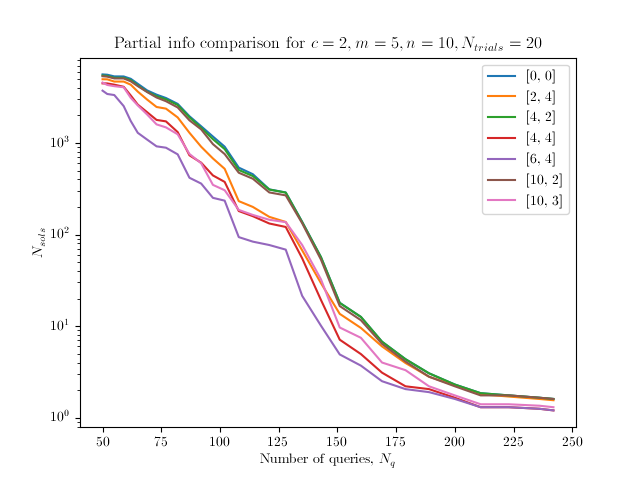

In [80]:
plt.figure()

x = data[1]
for i in data[0].keys():
    y = data[0][i]
    plt.plot(x, y, label = f'{i}')

    
plt.xlabel('Number of queries, $N_q$')
plt.ylabel('$N_{sols}$')
# plt.xscale('log')
plt.yscale('log')
# plt.title("Averages of methods, 40 trials, n=10, m=4, c=1")
plt.title(f'Partial info comparison for $c=2, m=5, n=10, N_{{trials}} =20$')
# plt.title(f"$c$")
# plt.ylim([0,105])
plt.legend()
# plt.savefig(f'compare_partials_data_additive/figures/c_2_m_5_n_10_first.pdf') 
plt.show()
# plt.close()


In [24]:
print(np.log(10))

2.302585092994046


In [9]:
n =100
m = 6
c = 1
N_q =20
db = gen_bin_data_set(n,m)
quer_seed_dict = query_seed_dict(m)
dist = 'uniform'
gen_queries_algo(db,m,quer_seed_dict,dist,c,N_q)

[5, 3, 4, 2, 0, 1]
[5] [0]
[5, 3] [0, 0]
[5, 3, 4] [0, 0, 0]
[5, 3, 4, 2] [0, 0, 0, 0]
[5, 3, 4, 2, 0] [0, 0, 0, 0, 1]
[5, 3, 4, 2, 0, 1] [0, 0, 0, 0, 1, 1]
[1, 4, 2, 3, 5, 0]
[1] [1]
[1, 4] [1, 1]
[1, 4, 2] [1, 1, 0]
[1, 4, 2, 3] [1, 1, 0, 0]
[1, 4, 2, 3, 5] [1, 1, 0, 0, 1]
[1, 4, 2, 3, 5, 0] [1, 1, 0, 0, 1, 0]


defaultdict(None,
            {((5,), (0,)): 51,
             ((5,), (1,)): 47,
             ((3, 5), (0, 0)): 28,
             ((3, 5), (1, 0)): 25,
             ((3, 4, 5), (0, 0, 0)): 14,
             ((3, 4, 5), (0, 1, 0)): 12,
             ((2, 3, 4, 5), (0, 0, 0, 0)): 10,
             ((2, 3, 4, 5), (1, 0, 0, 0)): 6,
             ((0, 2, 3, 4, 5), (0, 0, 0, 0, 0)): 2,
             ((0, 2, 3, 4, 5), (1, 0, 0, 0, 0)): 7,
             ((0, 1, 2, 3, 4, 5), (1, 0, 0, 0, 0, 0)): 2,
             ((0, 1, 2, 3, 4, 5), (1, 1, 0, 0, 0, 0)): 4,
             ((1,), (0,)): 44,
             ((1,), (1,)): 55,
             ((1, 4), (1, 0)): 24,
             ((1, 4), (1, 1)): 31,
             ((1, 2, 4), (1, 0, 1)): 18,
             ((1, 2, 4), (1, 1, 1)): 13,
             ((1, 2, 3, 4), (1, 0, 0, 1)): 10,
             ((1, 2, 3, 4), (1, 0, 1, 1)): 8,
             ((1, 2, 3, 4, 5), (1, 0, 0, 1, 0)): 3,
             ((1, 2, 3, 4, 5), (1, 0, 0, 1, 1)): 5,
             ((0, 1, 2, 3, 4, 5), (0, 1, 0, 

In [5]:
def identify_edges(quer_tails,quer_heads,numbering):
    edge_lst = []
    for tail in quer_tails:
        for head in quer_heads:
            if set(split_quer(tail)).issubset(set(split_quer(head))):
                edge_lst.append([numbering[tail],numbering[head]])
    return edge_lst
            
def split_quer(quer):
    lst = []
    for i,j in zip(quer[0],quer[1]):
        lst.append((i,j))
    return lst

def get_edges(numbering,m):
    quer_sizes = defaultdict(list)
    for query in numbering.keys():
        quer_sizes[len(query[0])].append(query)
    edges = []
    for i in range(0,m):
        edges += identify_edges(quer_sizes[i],quer_sizes[i+1],numbering)
    return edges

In [6]:
m = 3
numbering = defaultdict()
i = 0 
queries = gen_queries_all(m)
queries.append(((),()))
for quer in queries:
    numbering[quer] = i
    i+=1
edges = get_edges(numbering,m)

net = Network(notebook = True, layout = True, height='500px', width='100%')
# net.add_nodes(list(numbering.values()), label = [str(x) for x in numbering.keys()], level = [0 for x in numbering.keys()])
for query in queries:
    net.add_node(numbering[query], str(query), level = len(query[0]))

net.add_edges(edges)
net.show_buttons(filter_=['physics'])
# display(HTML('nodes.html'))
net.show('nodes_length_hierarchy.html')



Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


In [14]:
n = 10
m = 3
k = 10
c = 1
N_paths = 10
N_sols = 1000
dist = 'uniform'
sol_thresh = 20
bb_thresh = 0.7
db = gen_bin_data_set(n,m)
quer_seed_dict = query_seed_dict(m)
display(db)
quer_counts = get_quer_counts(db,m,c,quer_seed_dict,dist)
display(quer_counts)

#create numbering, doing it outside of function if need to translate numbering to network graph
numbering = bidict()
i = 0 
for quer in gen_queries_all(m):
    numbering[quer] = i
    i+=1

path_dicts = produce_paths(db,quer_seed_dict,n,m,c,dist,N_sols,k,N_paths,numbering)


display(numbering.inverse)

sol_avg_dict = quer_perf_avg(path_dicts,numbering)
# bb = list(sorted(sol_avg_dict.items(), key=lambda x:x[1]))
new_lst = []
for i in list(sorted(sol_avg_dict.items(), key=lambda x:x[1])):
    a = list(i)
    a.append(quer_counts[numbering.inverse[i[0]]])
    new_lst.append(a)
display(new_lst)

# good_paths_out = good_paths(path_dicts, numbering, sol_thresh, bb_thresh)[1]
# display(sorted(good_paths_out.items(), key=lambda x:x[1], reverse = True))

selection = []
for quer in new_lst[0:k]:
    selection.append(numbering.inverse[quer[0]])
print(get_n_sols(n,m,c,selection,quer_counts,N_sols))
selection_big_counts = gen_queries(m,n,db,c,quer_seed_dict,k,'large_counts_first',dist)
print(get_n_sols(n,m,c,selection_big_counts,quer_counts,N_sols))

,att_0,att_1,att_2
0,0,0,0
1,1,1,1
2,1,1,0
3,0,0,0
4,1,0,0
5,1,1,1
6,0,0,0
7,1,1,1
8,0,1,1
9,0,1,0


defaultdict(int,
            {((0, 1), (0, 0)): 4,
             ((0, 1, 2), (0, 0, 0)): 4,
             ((0, 1, 2), (0, 1, 0)): 1,
             ((0, 1, 2), (1, 1, 1)): 4,
             ((0, 2), (1, 0)): 1,
             ((0, 1, 2), (0, 1, 1)): 0,
             ((1, 2), (0, 1)): 0,
             ((0,), (1,)): 5,
             ((0, 1), (1, 1)): 3,
             ((2,), (0,)): 7,
             ((0, 1, 2), (1, 0, 1)): 0,
             ((1, 2), (1, 0)): 2,
             ((0, 1), (1, 0)): 2,
             ((0, 1, 2), (0, 0, 1)): 1,
             ((2,), (1,)): 4,
             ((0, 1, 2), (1, 0, 0)): 1,
             ((1,), (0,)): 3,
             ((0, 1), (0, 1)): 1,
             ((0,), (0,)): 4,
             ((1, 2), (0, 0)): 4,
             ((0, 2), (1, 1)): 2,
             ((1,), (1,)): 5,
             ((0, 2), (0, 0)): 5,
             ((0, 2), (0, 1)): 1,
             ((0, 1, 2), (1, 1, 0)): 1,
             ((1, 2), (1, 1)): 4})

bidict({0: ((0,), (0,)), 1: ((0,), (1,)), 2: ((1,), (0,)), 3: ((1,), (1,)), 4: ((2,), (0,)), 5: ((2,), (1,)), 6: ((0, 1), (0, 0)), 7: ((0, 1), (0, 1)), 8: ((0, 1), (1, 0)), 9: ((0, 1), (1, 1)), 10: ((0, 2), (0, 0)), 11: ((0, 2), (0, 1)), 12: ((0, 2), (1, 0)), 13: ((0, 2), (1, 1)), 14: ((1, 2), (0, 0)), 15: ((1, 2), (0, 1)), 16: ((1, 2), (1, 0)), 17: ((1, 2), (1, 1)), 18: ((0, 1, 2), (0, 0, 0)), 19: ((0, 1, 2), (0, 0, 1)), 20: ((0, 1, 2), (0, 1, 0)), 21: ((0, 1, 2), (0, 1, 1)), 22: ((0, 1, 2), (1, 0, 0)), 23: ((0, 1, 2), (1, 0, 1)), 24: ((0, 1, 2), (1, 1, 0)), 25: ((0, 1, 2), (1, 1, 1))})

[[2, 49.0, 3],
 [10, 54.5, 5],
 [25, 58.333333333333336, 4],
 [3, 64.6, 5],
 [19, 87.0, 1],
 [15, 87.66666666666667, 0],
 [13, 88.2, 2],
 [17, 89.0, 4],
 [23, 91.75, 0],
 [22, 95.0, 1],
 [14, 95.8, 4],
 [1, 103.0, 5],
 [24, 104.5, 1],
 [8, 107.14285714285714, 2],
 [0, 109.5, 4],
 [4, 114.2, 7],
 [7, 114.4, 1],
 [21, 116.375, 0],
 [6, 117.66666666666667, 4],
 [11, 125.0, 1],
 [9, 127.5, 3],
 [16, 131.5, 2],
 [5, 134.0, 4],
 [18, 147.0, 4],
 [12, 171.0, 1],
 [20, 229.0, 1]]

27
38


In [478]:
n = 10
m = 4
k = 10
c = 1
N_paths = 800
N_sols = 1000
dist = 'uniform'
# sol_thresh = 20
# bb_thresh = 0.7
db = gen_bin_data_set(n,m)
quer_seed_dict = query_seed_dict(m)
# display(db)
quer_counts = get_quer_counts(db,m,c,quer_seed_dict,dist)
# display(quer_counts)

#create numbering, doing it outside of function if need to translate numbering to network graph
numbering = bidict()
i = 0 
for quer in gen_queries_all(m):
    numbering[quer] = i
    i+=1
    
n_iters_SA = 1000
alpha = 0.99
t_0 = n_iters + 4
repeats = 100
simu_annealing(n_iters_SA,repeats,alpha,t_0,quer_counts,n,m,c,N_sols,k,numbering)

([1, 8, 40, 41, 43, 45, 61, 68, 71, 72], 1000)

In [533]:
max_quers(3)

26

## For a specific instance, printing out paths

In [11]:
n = 10
m = 3
k = 8
c = 1
N_paths = 400
N_sols = 1000
dist = 'uniform'
# sol_thresh = 20
# bb_thresh = 0.7
db = gen_bin_data_set(n,m)
quer_seed_dict = query_seed_dict(m)
display(db)
quer_counts = get_quer_counts(db,m,c,quer_seed_dict,dist)
# display(quer_counts)

#create numbering, doing it outside of function if need to translate numbering to network graph
numbering = bidict()
i = 0 
for quer in gen_queries_all(m):
    numbering[quer] = i
    i+=1
    
# display(numbering)
    
n_iters_GA = 100
pop_size = 100
n_crossovers = 5
n_mutants = 5
n_parents = 20
n_iters_SA = 1000
alpha = 0.95
t_0 = n_iters_SA + 4
repeats = 200
rand_trials = 50

SA = simu_annealing(n_iters_SA,repeats,alpha,t_0,quer_counts,n,m,c,N_sols,k,numbering)
print('SA:', SA, 'red')


GA = genetic_algo(n_iters_GA, pop_size,n_parents, n_crossovers, n_mutants, quer_counts,n,m,c,N_sols,k,numbering)
print('GA:', GA, 'green')

path_dicts = produce_paths(db,quer_seed_dict,n,m,c,dist,N_sols,k,N_paths,numbering)
sol_avg_dict = quer_perf_avg(path_dicts,numbering)
new_lst = []
for i in list(sorted(sol_avg_dict.items(), key=lambda x:x[1])):
    a = list(i)
    a.append(quer_counts[numbering.inverse[i[0]]])
    new_lst.append(a)
selection = []
for quer in new_lst[0:k]:
    selection.append(numbering.inverse[quer[0]])
    
good_paths = (sorted(tuple([numbering[x] for x in selection])), get_n_sols(n,m,c,selection,quer_counts,N_sols))
print('Good Paths:', good_paths, 'yellow')
selection_big_counts = gen_queries(m,n,db,c,quer_seed_dict,k,'large_counts_first',dist)

large_atts = (sorted(tuple([numbering[x] for x in selection_big_counts])), \
                      get_n_sols(n,m,c,selection_big_counts,quer_counts,N_sols))
print('Large Atts:', large_atts, 'pink')
print(f'Avg {rand_trials} trials:', ([],(int(np.mean([get_fitness(np.random.choice(range(max_quers(m)),k),n,m,c,quer_counts,N_sols,numbering) \
                                            for i in range(rand_trials)])))))





net = Network(notebook = True, height='1000px', width='90%', directed=True,
              # layout = True
             )
# net.add_nodes(list(numbering.values()), label = [str(x) for x in numbering.keys()], level = [0 for x in numbering.keys()])
for query in quer_counts.keys():
    net.add_node(numbering[query], str(query)+': '+str(quer_counts[query]), 
                 # level = len(query[0])
                )
    
# edges = get_edges(numbering,m)
# net.add_edges(edges)
    
def my_add_edges(path,colour,network):
    for i in range(len(path) - 1):
        network.add_edge(int(path[i]),int(path[i+1]), color = colour, value =3)
    return None

my_add_edges(SA[0],'red',net)
my_add_edges(GA[0],'green',net)
my_add_edges(good_paths[0],'yellow',net)
my_add_edges(large_atts[0],'pink',net)
net.set_edge_smooth('dynamic')
net.show_buttons(filter_=['physics'])
# display(HTML('nodes.html'))
# net.show('alg_comp_paths.html')

,att_0,att_1,att_2
0,1,1,1
1,1,1,1
2,1,1,1
3,0,0,1
4,0,0,1
5,1,0,1
6,1,0,0
7,1,0,0
8,0,0,1
9,0,0,1


SA: ([0, 2, 3, 5, 15, 16, 19, 25], 1) red
GA: ([0, 3, 5, 8, 13, 15, 17, 19], 1) green
Good Paths: ([0, 1, 3, 5, 6, 11, 15, 19], 1) yellow
Large Atts: ([1, 2, 5, 6, 9, 11, 15, 19], 33) pink
Avg 50 trials: ([], 205)
Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


## going to get some average results using this..

In [10]:
n = 5
m = 5
k = 20
c = 1
N_paths = 400
N_sols = 1000
dist = 'uniform'
# sol_thresh = 20
# bb_thresh = 0.7
db = gen_bin_data_set(n,m)
quer_seed_dict = query_seed_dict(m)
# display(db)
quer_counts = get_quer_counts(db,m,c,quer_seed_dict,dist)
# display(quer_counts)

#create numbering, doing it outside of function if need to translate numbering to network graph
numbering = bidict()
i = 0 
for quer in gen_queries_all(m):
    numbering[quer] = i
    i+=1
    
n_iters_GA = 100
pop_size = 100
n_crossovers = 5
n_mutants = 5
n_parents = 20
n_iters_SA = 1000
alpha = 0.95
t_0 = n_iters_SA + 4
repeats = 2
rand_trials = 50

SA = simu_annealing(n_iters_SA,repeats,alpha,t_0,quer_counts,n,m,c,N_sols,k,numbering)


# def gen_paths_SA(numbering,N_trials,dist,n_iters_SA,repeats,alpha,t_0,quer_counts,n,m,c,N_sols,k):
    
#     results = defaultdict()
#     for i in range(N_trials):
#         db = gen_bin_data_set(n,m)
#         quer_seed_dict = query_seed_dict(m)
#         quer_counts = get_quer_counts(db,m,c,quer_seed_dict,dist)
        
#         print(quer_counts)
#     return None


# net = Network(notebook = True, height='1000px', width='90%', directed=True,
#               # layout = True
#              )
# # net.add_nodes(list(numbering.values()), label = [str(x) for x in numbering.keys()], level = [0 for x in numbering.keys()])
# for query in quer_counts.keys():
#     net.add_node(numbering[query], str(query)+': '+str(quer_counts[query]), 
#                  # level = len(query[0])
#                 )
    
# # edges = get_edges(numbering,m)
# # net.add_edges(edges)
    
# def my_add_edges(path,colour,network):
#     for i in range(len(path) - 1):
#         network.add_edge(int(path[i]),int(path[i+1]), color = colour, value =3)
#     return None

# my_add_edges(SA[0],'red',net)
# # # my_add_edges(GA[0],'green',net)
# # # my_add_edges(good_paths[0],'yellow',net)
# # # my_add_edges(large_atts[0],'pink',net)
# net.set_edge_smooth('dynamic')
# net.show_buttons(filter_=['physics'])
# display(HTML('nodes.html'))
# net.show('alg_comp_paths_test.html')

In [15]:
#create numbering, doing it outside of function if need to translate numbering to network graph
m = 5
numbering = bidict()
i = 0 
for quer in gen_queries_all(m):
    numbering[quer] = i
    i+=1
n_iters_GA = 100
pop_size = 100
n_crossovers = 5
n_mutants = 5
n_parents = 20
n_iters_SA = 1000
alpha = 0.95
t_0 = n_iters_SA + 4
repeats = 2
rand_trials = 50
n = 5
k = 20
c = 1
N_paths = 400
N_sols = 1000
dist = 'uniform'
N_trials = 150
k_low = 5
k_high = 15
# data = gen_paths_SA(numbering,N_trials,dist,n_iters_SA,repeats,alpha,t_0,quer_counts,n,m,c,N_sols,k)
# # data = gen_paths_SA_additive_k(numbering,dist,n_iters_SA,repeats,alpha,t_0,quer_counts,n,m,c,N_sols,k_low,k_high)

# # print(os.getcwd())
# filename = f'SA_paths_k_additive/n_{n}_m_{m}_k_l_{k_low}_k_h_{k_high}_N_t_{N_trials}_same_db.json'
# os.makedirs(os.path.dirname(filename), exist_ok=True)
# with open(filename, 'w') as f: 
#     json.dump(data, f)

In [245]:
path = 'differential_privacy/toy_model_ILP/SA_paths_k_additive/n_5_m_3_k_l_5_k_h_15_N_t_50_same_db.json'
f = open(path2filename(path))
res_dict = json.load(f)
display(res_dict)
paths_used = 50

net = Network(notebook = True, height='1000px', width='90%', 
              directed=True,
              # filter_menu=True,
              # select_menu=True,
              # layout = True
             )
# net.add_nodes(list(numbering.values()), label = [str(x) for x in numbering.keys()], level = [0 for x in numbering.keys()])
# for query in quer_counts.keys():
#     net.add_node(numbering[query], str(query)+': '+str(quer_counts[query]), 
#                  # level = len(query[0])
#                 )

my_add_nodes(paths_used,net,res_dict,numbering)
    
# edges = get_edges(numbering,m)
# net.add_edges(edges)
    
my_add_edges(paths_used,res_dict,'red',net)

# my_add_edges(SA[0],'red',net)
# # # my_add_edges(GA[0],'green',net)
# # # my_add_edges(good_paths[0],'yellow',net)
# # # my_add_edges(large_atts[0],'pink',net)
net.set_edge_smooth('dynamic')
net.show_buttons(filter_=['physics'])
# display(HTML('nodes.html'))
net.show('network_html/small_m_additive_k.html')

{'5': [[5, 6, 13, 15, 25], 1],
 '6': [[5, 6, 9, 13, 15, 24], 1],
 '7': [[0, 3, 5, 6, 12, 13, 25], 1],
 '8': [[5, 6, 11, 13, 15, 20, 22, 23], 1],
 '9': [[1, 3, 4, 5, 6, 10, 13, 17, 20], 1],
 '10': [[3, 5, 6, 13, 14, 15, 16, 20, 24, 25], 1],
 '11': [[2, 6, 12, 13, 14, 15, 17, 21, 22, 23, 24], 1],
 '12': [[3, 5, 6, 8, 9, 11, 12, 13, 15, 16, 21, 25], 1],
 '13': [[0, 2, 3, 6, 8, 9, 13, 14, 15, 17, 19, 20, 25], 1],
 '14': [[3, 4, 6, 7, 8, 9, 10, 13, 15, 17, 18, 20, 21, 25], 1],
 '15': [[0, 3, 4, 5, 6, 7, 9, 11, 13, 15, 17, 21, 22, 24, 25], 1]}

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


In [144]:
filename = 'SA_paths/m_5_k_20_first_try.json'
f = open(filename)
res_dict = json.load(f)
# display(res_dict)
paths_used = 50

import networkx as nx
G = nx.Graph()


# net = Network(notebook = True, height='1000px', width='90%', 
#               # directed=True,
#               # layout = True
#              )
# # net.add_nodes(list(numbering.values()), label = [str(x) for x in numbering.keys()], level = [0 for x in numbering.keys()])
# # for query in quer_counts.keys():
# #     net.add_node(numbering[query], str(query)+': '+str(quer_counts[query]), 
# #                  # level = len(query[0])
# #                 )

# my_add_nodes(paths_used,net,res_dict,numbering)
    
# # edges = get_edges(numbering,m)
# # net.add_edges(edges)
    
# my_add_edges(paths_used,res_dict,'red',net)

In [148]:
print(*(1,3,5))

(1, 3, 5)


In [185]:
s = 'differential_privacy/toy_model_ILP/SA_paths/n_5_m_5_k_20_N_t_50_same_db.json'
print(len(s))
print(s.lstrip(os.getcwd()))


76
SA_paths/n_5_m_5_k_20_N_t_50_same_db.json


In [240]:
net = Network(notebook = True, height='1000px', width='90%', 
              directed=True,
              # filter_menu=True,
              # select_menu=True,
              # layout = True
             )
# net.add_nodes(list(numbering.values()), label = [str(x) for x in numbering.keys()], level = [0 for x in numbering.keys()])
# for query in quer_counts.keys():
#     net.add_node(numbering[query], str(query)+': '+str(quer_counts[query]), 
#                  # level = len(query[0])
#                 )

my_add_nodes(paths_used,net,res_dicty,numbering)
    
# edges = get_edges(numbering,m)
# net.add_edges(edges)
    
my_add_edges(paths_used,res_dicty,'red',net)

# my_add_edges(SA[0],'red',net)
# # # my_add_edges(GA[0],'green',net)
# # # my_add_edges(good_paths[0],'yellow',net)
# # # my_add_edges(large_atts[0],'pink',net)
net.set_edge_smooth('dynamic')
net.show_buttons(filter_=['physics'])
# display(HTML('nodes.html'))
# net.show('network_html/tststststtstestest.html')

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


In [20]:
# def noise_SA(numbering,N_trials,dist,n_iters_SA,repeats,alpha,t_0,quer_counts,n,m,c,N_sols,k):
    
#     results = defaultdict()
#     db = gen_bin_data_set(n,m)
#     for i in range(N_trials):
#         if i%10 ==1:
#             print(i)
#         quer_seed_dict = query_seed_dict(m)
#         quer_counts = get_quer_counts(db,m,c,quer_seed_dict,dist)
#         results[i] = simu_annealing(n_iters_SA,repeats,alpha,t_0,quer_counts,n,m,c,N_sols,k,numbering)
        
#     return results


# create numbering, doing it outside of function if need to translate numbering to network graph
m = 5
numbering = bidict()
i = 0 
for quer in gen_queries_all(m):
    numbering[quer] = i
    i+=1
    
n_iters_GA = 100
pop_size = 100
n_crossovers = 5
n_mutants = 5
n_parents = 20
n_iters_SA = 1000
alpha = 0.95
t_0 = n_iters_SA + 4
repeats = 2
rand_trials = 50
n = 5
k = 8
c = 1
N_paths = 400
N_sols = 1000
dist = 'uniform'
N_trials = 150
k_low = 5
k_high = 15

db = gen_bin_data_set(n,m)
quer_seed_dict = query_seed_dict(m)
quer_counts = get_quer_counts(db,m,c,quer_seed_dict,dist)

res_dicty = defaultdict()
for b in range(10):
    temp = simu_annealing(n_iters_SA,repeats,alpha,t_0,quer_counts,n,m,c,N_sols,k,numbering)
    res_dicty[str(b)] = temp
print(res_dicty)

defaultdict(None, {'0': ((30, 71, 84, 111, 134, 146, 149, 230), 2), '1': ((6, 26, 50, 71, 111, 121, 162, 230), 2), '2': ((18, 26, 30, 51, 71, 91, 111, 198), 1), '3': ((22, 51, 115, 134, 162, 176, 194, 198), 3), '4': ((2, 15, 82, 127, 134, 162, 198, 218), 1), '5': ((39, 84, 88, 117, 120, 143, 160, 173), 1000), '6': ((2, 6, 26, 76, 90, 111, 190, 200), 4), '7': ((6, 76, 84, 106, 108, 111, 127, 130), 4), '8': ((0, 12, 30, 51, 71, 111, 134, 198), 4), '9': ((1, 2, 6, 26, 76, 90, 111, 140), 3)})


In [35]:
def paths2pandas(res_dict):
    main_lst = []
    edge_count = defaultdict(lambda:0)
    for path in res_dict.values():
        for i in range(len(path[0])-1):
            edge = (path[0][i], path[0][i+1])
            edge_count[edge] += 1
    out_lst = []
    for i in edge_count.items():
        temp = []
        temp.append(i[0][0])
        temp.append(i[0][1])
        temp.append(i[1])
        out_lst.append(temp)

    return pd.DataFrame(out_lst, columns=['from', 'to', 'weight']), edge_count

# path = 'differential_privacy/toy_model_ILP/SA_paths/n_5_m_5_k_l_5_k_h_15_N_t_150_same_db.json'
# f = open(path2filename(path))
# res_dict = json.load(f)
# display(res_dict)
paths_used = 5

path_nodes = Counter()
# for i in range(min(len(res_dict.values()),paths_used)):
for i in res_dicty.keys():
    path_nodes.update(res_dicty[str(i)][0])

temp_data = paths2pandas(res_dicty)


g = nx.Graph()
for i, (source, target, weight) in temp_data[0].iterrows():
    width = weight
    g.add_edge(source, target, size=width, color='blue' if width > 3 else 'black')
    
# gv.d3(g)
nt = Network('500px', '100%',notebook = True)

sources = temp_data[0]['from']
targets = temp_data[0]['to']
weights = temp_data[0]['weight']

edge_data = zip(sources, targets, weights)

m=5
numbering = bidict()
i = 0 
for quer in gen_queries_all(m):
    numbering[quer] = i
    i+=1
# print(numbering.inverse)

for e in edge_data:
    src = e[0]
    dst = e[1]
    w = str(e[2])

    nt.add_node(src, str(src), title=str(numbering.inverse[src])+ ': '+ str(quer_counts[numbering.inverse[src]]) + '\n' + 'visits: ' + str(path_nodes[src]) + '\n')
    nt.add_node(dst, str(dst), title=str(numbering.inverse[dst])+ ': '+ str(quer_counts[numbering.inverse[dst]]) + '\n' + 'visits: ' + str(path_nodes[dst]) + '\n')
    nt.add_edge(src, dst, value=w, title = temp_data[1][(src,dst)])

neighbor_map = nt.get_adj_list()
# print(neighbor_map)

# add neighbor data to node hover data
for node in nt.nodes:
    node["title"] += " Neighbors: \n" + "\n".join([str(x) for x in neighbor_map[node["id"]]])
    # node["title"] += " Neighbors: \n" + "\n".join(str(neighbor_map[node["id"]]))
    # node["value"] = len(neighbor_map[node["id"]])
    node["value"] = path_nodes[node["id"]]

display(db)
# print(quer_counts[(2,4),()])
nt.show_buttons(filter_=['physics'])
new_sol = (18, 30, 51, 71, 91, 111, 198)
for i in new_sol: print(str(i) +': '+ str(numbering.inverse[i])+ ': '+ str(quer_counts[numbering.inverse[i]]))
print(get_fitness(new_sol,n,m,c,quer_counts,N_sols,numbering))
# new_sol = [7, 18, 39, 40, 66, 70, 148,155]
# print(get_fitness(new_sol,n,m,c,quer_counts,N_sols,numbering))
nt.show("network_html/large_m_same_db_SA_few_times.html")

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


,att_0,att_1,att_2,att_3,att_4
0,0,1,0,0,1
1,0,0,1,0,0
2,1,0,1,0,1
3,0,0,0,0,0
4,1,0,1,0,0


18: ((0, 3), (0, 0)): 4
30: ((1, 3), (0, 0)): 5
51: ((0, 1, 2), (0, 0, 1)): 0
71: ((0, 1, 4), (1, 0, 1)): 2
91: ((0, 3, 4), (0, 0, 1)): 0
111: ((1, 2, 4), (1, 0, 1)): 2
198: ((1, 2, 3, 4), (0, 1, 0, 0)): 3
2


In [306]:
# filename = f'small_example_data/n_{n}_m_{m}_example_1_quer_counts.json'
# os.makedirs(os.path.dirname(filename), exist_ok=True)
# with open(filename, 'w') as f: 
#     json.dump(dict((str(x),quer_counts[x]) for x in quer_counts.keys()), f)

In [313]:
import time as t
print(t.time())

1666322350.975565


In [24]:
alt_sols = produce_alt_paths((18, 26, 30, 51, 71, 91, 111, 198),10,n,m,c,quer_counts,N_sols,numbering)
display(alt_sols)
temp_dicty = defaultdict()
mm = 0
for sol in alt_sols:
    temp_dicty[str(mm)] = (tuple(sorted(sol)), 1)
    mm+=1

{(18, 26, 30, 15, 71, 91, 111, 198),
 (18, 26, 30, 51, 25, 91, 111, 198),
 (18, 26, 30, 51, 35, 91, 111, 198),
 (18, 26, 30, 51, 71, 23, 111, 198),
 (18, 26, 30, 51, 71, 91, 111, 9),
 (18, 26, 30, 51, 71, 91, 111, 46),
 (18, 26, 30, 51, 71, 91, 111, 47),
 (18, 26, 30, 51, 71, 91, 111, 88),
 (18, 26, 30, 51, 71, 91, 111, 89),
 (18, 26, 30, 51, 71, 91, 111, 95),
 (18, 26, 30, 51, 71, 91, 111, 108),
 (18, 26, 30, 51, 71, 91, 111, 109),
 (18, 26, 30, 51, 71, 91, 111, 171),
 (18, 26, 30, 51, 71, 106, 111, 198),
 (18, 26, 30, 51, 71, 122, 111, 198),
 (18, 26, 30, 51, 71, 146, 111, 198),
 (18, 26, 30, 51, 71, 162, 111, 198),
 (18, 26, 30, 51, 71, 179, 111, 198),
 (18, 26, 30, 51, 115, 91, 111, 198),
 (18, 26, 30, 51, 156, 91, 111, 198),
 (18, 26, 30, 76, 71, 91, 111, 198),
 (18, 38, 30, 51, 71, 91, 111, 198),
 (18, 127, 30, 51, 71, 91, 111, 198)}

In [26]:
temp_lst = []
for i in list(alt_sols):
    for j in list(set(i) - set((18, 26, 30, 51, 71, 91, 111, 198))):
        print(str(j) +': '+ str(numbering.inverse[j])+ ': '+ str(quer_counts[numbering.inverse[j]]))

156: ((0, 1, 2, 4), (1, 0, 1, 0)): 0
162: ((0, 1, 3, 4), (0, 0, 0, 0)): 3
35: ((1, 4), (0, 1)): 2
15: ((0, 2), (0, 1)): 0
108: ((1, 2, 4), (0, 1, 0)): 3
38: ((2, 3), (0, 0)): 1
47: ((3, 4), (0, 1)): 1
127: ((2, 3, 4), (1, 0, 1)): 2
122: ((2, 3, 4), (0, 0, 0)): 2
89: ((0, 2, 4), (1, 1, 1)): 0
95: ((0, 3, 4), (1, 0, 1)): 0
146: ((0, 1, 2, 4), (0, 0, 0, 0)): 2
46: ((3, 4), (0, 0)): 4
171: ((0, 1, 3, 4), (1, 0, 0, 1)): 0
106: ((1, 2, 4), (0, 0, 0)): 2
23: ((0, 4), (0, 1)): 0
9: ((4,), (1,)): 1
115: ((1, 3, 4), (0, 0, 1)): 2
88: ((0, 2, 4), (1, 1, 0)): 2
25: ((0, 4), (1, 1)): 2
109: ((1, 2, 4), (0, 1, 1)): 0
76: ((0, 2, 3), (0, 1, 0)): 0
179: ((0, 2, 3, 4), (0, 0, 0, 1)): 0


In [348]:
display(temp_dicty)

defaultdict(None,
            {'0': ((7, 39, 40, 66, 70, 92, 155), 1),
             '1': ((18, 38, 39, 40, 66, 70, 155), 1),
             '2': ((18, 39, 40, 66, 70, 155, 189), 1),
             '3': ((18, 39, 40, 62, 66, 70, 155), 1),
             '4': ((18, 39, 40, 66, 70, 155, 229), 1),
             '5': ((7, 39, 40, 66, 70, 155, 164), 1),
             '6': ((6, 18, 39, 40, 66, 70, 155), 1),
             '7': ((18, 39, 40, 63, 66, 70, 155), 1),
             '8': ((7, 39, 40, 58, 66, 70, 155), 1),
             '9': ((7, 39, 40, 66, 70, 77, 155), 1),
             '10': ((7, 18, 39, 40, 66, 155, 230), 1),
             '11': ((18, 39, 40, 66, 70, 155, 187), 1),
             '12': ((18, 39, 40, 66, 70, 155, 227), 1),
             '13': ((7, 39, 40, 66, 70, 155, 230), 1),
             '14': ((18, 39, 40, 49, 66, 70, 155), 1),
             '15': ((18, 21, 39, 40, 66, 70, 155), 1),
             '16': ((18, 30, 39, 40, 66, 70, 155), 1),
             '17': ((18, 39, 40, 66, 70, 155, 197), 1)})

In [31]:
def paths2pandas(res_dict):
    main_lst = []
    edge_count = defaultdict(lambda:0)
    for path in res_dict.values():
        for i in range(len(path[0])-1):
            edge = (path[0][i], path[0][i+1])
            edge_count[edge] += 1
    out_lst = []
    for i in edge_count.items():
        temp = []
        temp.append(i[0][0])
        temp.append(i[0][1])
        temp.append(i[1])
        out_lst.append(temp)

    return pd.DataFrame(out_lst, columns=['from', 'to', 'weight']), edge_count

# path = 'differential_privacy/toy_model_ILP/SA_paths/n_5_m_5_k_l_5_k_h_15_N_t_150_same_db.json'
# f = open(path2filename(path))
# res_dict = json.load(f)
# display(res_dict)
# paths_used = 5

path_nodes = Counter()
# for i in range(min(len(res_dict.values()),paths_used)):
for i in temp_dicty.keys():
    path_nodes.update(temp_dicty[str(i)][0])

temp_data = paths2pandas(temp_dicty)


g = nx.Graph()
for i, (source, target, weight) in temp_data[0].iterrows():
    width = weight
    g.add_edge(source, target, size=width, color='blue' if width > 3 else 'black')
    
# gv.d3(g)
nt = Network('500px', '100%',notebook = True)

sources = temp_data[0]['from']
targets = temp_data[0]['to']
weights = temp_data[0]['weight']

edge_data = zip(sources, targets, weights)

m=5
numbering = bidict()
i = 0 
for quer in gen_queries_all(m):
    numbering[quer] = i
    i+=1
# print(numbering.inverse)

for e in edge_data:
    src = e[0]
    dst = e[1]
    w = str(e[2])

    nt.add_node(src, str(src), title=str(numbering.inverse[src])+ ': '+ str(quer_counts[numbering.inverse[src]]) + '\n' + 'visits: ' + str(path_nodes[src]) + '\n')
    nt.add_node(dst, str(dst), title=str(numbering.inverse[dst])+ ': '+ str(quer_counts[numbering.inverse[dst]]) + '\n' + 'visits: ' + str(path_nodes[dst]) + '\n')
    nt.add_edge(src, dst, value=w, title = temp_data[1][(src,dst)])

neighbor_map = nt.get_adj_list()
# print(neighbor_map)

# add neighbor data to node hover data
for node in nt.nodes:
    node["title"] += " Neighbors: \n" + "\n".join([str(x) for x in neighbor_map[node["id"]]])
    # node["title"] += " Neighbors: \n" + "\n".join(str(neighbor_map[node["id"]]))
    # node["value"] = len(neighbor_map[node["id"]])
    node["value"] = path_nodes[node["id"]]

display(db)
# print(quer_counts[(2,4),()])
nt.show_buttons(filter_=['physics'])
# new_sol = [7, 18, 39, 40, 66, 70, 155]
# for i in new_sol: print(str(i) +': '+ str(numbering.inverse[i])+ ': '+ str(quer_counts[numbering.inverse[i]]))
# print(get_fitness(new_sol,n,m,c,quer_counts,N_sols,numbering))
# new_sol = [7, 18, 39, 40, 66, 70, 148,155]
# print(get_fitness(new_sol,n,m,c,quer_counts,N_sols,numbering))
nt.show("small_example_data/minimal_paths_test.html")

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


,att_0,att_1,att_2,att_3,att_4
0,0,1,0,0,1
1,0,0,1,0,0
2,1,0,1,0,1
3,0,0,0,0,0
4,1,0,1,0,0


In [29]:
new_sol = [18,26,30,51,91,111]
print(get_fitness(new_sol,n,m,c,quer_counts,N_sols,numbering))

3


In [347]:
paths_used = 50
net = Network(notebook = True, height='1000px', width='90%', 
              directed=True,
              # filter_menu=True,
              # select_menu=True,
              # layout = True
             )
# net.add_nodes(list(numbering.values()), label = [str(x) for x in numbering.keys()], level = [0 for x in numbering.keys()])
# for query in quer_counts.keys():
#     net.add_node(numbering[query], str(query)+': '+str(quer_counts[query]), 
#                  # level = len(query[0])
#                 )

my_add_nodes(paths_used,net,temp_dicty,numbering,2)
    
# edges = get_edges(numbering,m)
# net.add_edges(edges)
    
my_add_edges(paths_used,temp_dicty,'red',net)

# my_add_edges(SA[0],'red',net)
# # # my_add_edges(GA[0],'green',net)
# # # my_add_edges(good_paths[0],'yellow',net)
# # # my_add_edges(large_atts[0],'pink',net)
net.set_edge_smooth('dynamic')
net.show_buttons(filter_=['physics'])
# display(HTML('nodes.html'))
net.show("small_example_data/minimal_paths_test_2.html")

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


In [353]:
alt_sols

{(6, 18, 39, 40, 66, 70, 155),
 (7, 18, 39, 40, 66, 230, 155),
 (7, 58, 39, 40, 66, 70, 155),
 (7, 77, 39, 40, 66, 70, 155),
 (7, 92, 39, 40, 66, 70, 155),
 (7, 164, 39, 40, 66, 70, 155),
 (7, 230, 39, 40, 66, 70, 155),
 (21, 18, 39, 40, 66, 70, 155),
 (30, 18, 39, 40, 66, 70, 155),
 (38, 18, 39, 40, 66, 70, 155),
 (49, 18, 39, 40, 66, 70, 155),
 (62, 18, 39, 40, 66, 70, 155),
 (63, 18, 39, 40, 66, 70, 155),
 (187, 18, 39, 40, 66, 70, 155),
 (189, 18, 39, 40, 66, 70, 155),
 (197, 18, 39, 40, 66, 70, 155),
 (227, 18, 39, 40, 66, 70, 155),
 (229, 18, 39, 40, 66, 70, 155)}

In [355]:
tru_counts = get_quer_counts(db,m,0,quer_seed_dict,dist)

In [370]:
out_lst = []
for trial in res_dicty.values():
    noise_output_dict = defaultdict(lambda: 0)
    if trial[1] <= 3:
        for i in trial[0]:
            noise_output_dict[quer_counts[numbering.inverse[i]] - tru_counts[numbering.inverse[i]]] += 1
        out_lst.append(noise_output_dict)
display(out_lst)

[defaultdict(<function __main__.<lambda>()>, {-1: 1, 1: 7}),
 defaultdict(<function __main__.<lambda>()>, {1: 6, -1: 2}),
 defaultdict(<function __main__.<lambda>()>, {1: 5, -1: 3}),
 defaultdict(<function __main__.<lambda>()>, {1: 6, -1: 2}),
 defaultdict(<function __main__.<lambda>()>, {1: 7, 0: 1}),
 defaultdict(<function __main__.<lambda>()>, {1: 8}),
 defaultdict(<function __main__.<lambda>()>, {1: 6, -1: 1, 0: 1}),
 defaultdict(<function __main__.<lambda>()>, {-1: 4, 1: 4}),
 defaultdict(<function __main__.<lambda>()>, {1: 5, -1: 3}),
 defaultdict(<function __main__.<lambda>()>, {1: 6, -1: 2}),
 defaultdict(<function __main__.<lambda>()>, {1: 7, -1: 1}),
 defaultdict(<function __main__.<lambda>()>, {1: 5, -1: 3}),
 defaultdict(<function __main__.<lambda>()>, {-1: 1, 1: 5, 0: 2})]

In [372]:
out_lst = []
for trial in res_dicty.values():
    noise_output_dict = defaultdict(lambda: 0)
    if trial[1] <= 3:
        for i in trial[0]:
            noise_output_dict[len(numbering.inverse[i][0])] += 1
        out_lst.append(noise_output_dict)
display(out_lst)

[defaultdict(<function __main__.<lambda>()>, {2: 3, 3: 4, 5: 1}),
 defaultdict(<function __main__.<lambda>()>, {2: 4, 3: 4}),
 defaultdict(<function __main__.<lambda>()>, {2: 4, 3: 4}),
 defaultdict(<function __main__.<lambda>()>, {2: 4, 3: 3, 4: 1}),
 defaultdict(<function __main__.<lambda>()>, {1: 1, 2: 2, 3: 4, 5: 1}),
 defaultdict(<function __main__.<lambda>()>, {2: 1, 3: 4, 4: 2, 5: 1}),
 defaultdict(<function __main__.<lambda>()>, {1: 1, 2: 2, 3: 1, 4: 3, 5: 1}),
 defaultdict(<function __main__.<lambda>()>, {2: 3, 3: 3, 4: 1, 5: 1}),
 defaultdict(<function __main__.<lambda>()>, {1: 1, 2: 4, 3: 2, 4: 1}),
 defaultdict(<function __main__.<lambda>()>, {1: 1, 2: 1, 3: 4, 5: 2}),
 defaultdict(<function __main__.<lambda>()>, {1: 1, 2: 3, 3: 3, 4: 1}),
 defaultdict(<function __main__.<lambda>()>, {1: 1, 2: 3, 3: 4}),
 defaultdict(<function __main__.<lambda>()>, {1: 1, 3: 1, 4: 5, 5: 1})]

In [ ]:
out_lst = []
for trial in res_dicty.values():
    noise_output_dict = defaultdict(lambda: 0)
    if trial[1] <= 3:
        for i in trial[0]:
            noise_output_dict[len(numbering.inverse[i][0])] += 1
        out_lst.append(noise_output_dict)
display(out_lst)

In [16]:
n = 10
m = 5
dist = 'uniform'
out = []
for i in range(10):
    db = gen_bin_data_set(n,m)
    quer_seed_dict = query_seed_dict(m)
    quers_all = gen_queries_uniform_complete(m,max_quers(m))
    all_quer_counts = get_quer_counts(db,m,0,quer_seed_dict,dist)
    out += list(all_quer_counts.values())
count = Counter(out)
print(count)
ll = {}
for i in range(11):
    ll[i] = count[i]/len(out)
    
print(ll[0] + ll[1] + ll[2])

Counter({0: 906, 1: 714, 2: 395, 3: 202, 4: 105, 5: 47, 6: 30, 7: 13, 8: 8})
0.8326446280991735


In [11]:
bb = Counter([1,1,2,3])
bb[1]

2